In [50]:
import os
import torch
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid

In [51]:
import wandb
wandb.login()

True

In [52]:
datapath = "../../../datasets/"

In [53]:
run = 1
wandb.init( project = 'fedgdrop',
        name=f'louvain-degree-dist-vis-v{run}' 
    )

In [54]:
def torch_load(base_dir, filename):
    fpath = os.path.join(base_dir, filename)    
    return torch.load(fpath, map_location=torch.device('cpu'))

def get_degree_list(x):
    G = to_networkx(x, to_undirected=True)
    degrees = [val for (node, val) in G.degree()]
    return degrees

In [55]:
def wandb_save_boxplot(x, n_clients, dset, title , key, lim):
    fig, ax = plt.subplots()
    ax.axes.set_xlim(left = -5, right = lim)
    ax.boxplot(x.values(), vert = False)
    for client_id in range(n_clients):
        ds = f'{client_id}-{dset}'
        ax.scatter(x = x[ds] + np.random.normal(loc =0, scale= 0.05, size = len(x[ds])), y=np.random.normal(loc = client_id+1, scale= 0.15, size = len(x[ds])))    
    ax.set_title(title)
    wandb.log({key : wandb.Image(plt)})

In [56]:
def wandb_save_hist(x, n_clients, k, dset , key, nbins = 50):
    fig, axs = plt.subplots(n_clients // k , k )
    vals , bins = np.zeros((n_clients, nbins)) , np.zeros((n_clients, nbins + 1))
    fig.tight_layout()
    for client_id in range(n_clients):
        ds = f'{client_id}-{dset}'
        if n_clients // k == 1 :
            vals[client_id , :], bins[client_id , :], _ = axs[client_id].hist(x[ds], nbins, density = True)
            axs[client_id].set_title(f"Client {client_id+1}")
        else:
            vals[client_id , :], bins[client_id , :], _ =axs[client_id // k , client_id % k].hist(x[ds], nbins, density = True)
            axs[client_id // k , client_id % k].set_title(f"Client {client_id+1}")
    wandb.log({key : wandb.Image(plt)})
    return vals, bins

In [57]:
def hellinger_dot(p, q):
    """Hellinger distance between two discrete distributions. 
       Using numpy.
       For Python >= 3.5 only"""
    z = np.sqrt(p) - np.sqrt(q)
    return np.sqrt(z @ z / 2)

def wandb_pairwise_hellinger(vals, n_clients, key, title):
    pwise_hell = np.zeros((n_clients, n_clients))

    for i in range(n_clients):
        for j in range(n_clients):
            pwise_hell[i,j] = hellinger_dot(vals[i,:]/sum(vals[i,:]), vals[j,:]/sum(vals[j,:]))
    #Plot the heatmap
    print(f"The Min HD: {np.min(pwise_hell)}")
    print(f"The Max HD: {np.max(pwise_hell)}")
    print(f"Average Off-Diagonal HD: {np.mean(pwise_hell[np.where(~np.eye(pwise_hell.shape[0],dtype=bool))])}")
    plt.matshow(pwise_hell)
    plt.colorbar(location="bottom")
    plt.title(title)
    plt.tight_layout()
    wandb.log({key : wandb.Image(plt)})

In [58]:
def wandb_pairwise_emd(vals, bins, n_clients, key, title):
    pwise_emd = np.zeros((n_clients, n_clients))
    for i in range(n_clients):
        for j in range(n_clients):
            pwise_emd[i,j] = wasserstein_distance(bins[i,:-1], bins[j,:-1], vals[i,:], vals[j,:])
    #Plot the heatmap
    print(f"The Min EMD: {np.min(pwise_emd)}")
    print(f"The Max EMD: {np.max(pwise_emd)}")
    print(f"Average Off-Diagonal EMD: {np.mean(pwise_emd[np.where(~np.eye(pwise_emd.shape[0],dtype=bool))])}")
    plt.matshow(pwise_emd)
    plt.colorbar(location="bottom")
    plt.title(title)
    plt.tight_layout()
    wandb.log({key : wandb.Image(plt)})

## Cora Dataset

### Degree Distribution of Cora Dataset

In [10]:
dataset = Planetoid(root=datapath, name='Cora')
data = dataset[0]

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


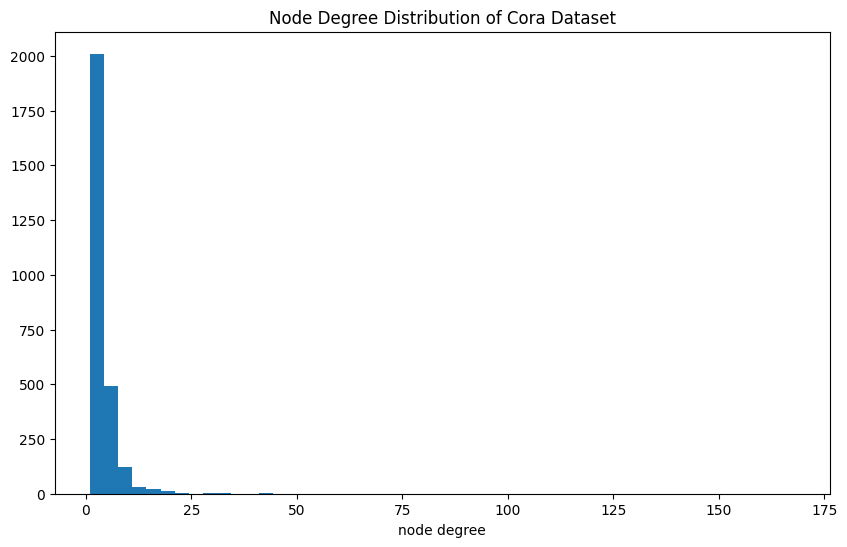

In [11]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.title("Node Degree Distribution of Cora Dataset")
plt.show()

### Clients' Degree Distribution via Boxplots

#### 5 Clients - v2

In [12]:
degreev2_dict_cora5 = {}
for client_id in range(5):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v2_Louvain/5/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_cora5[ds] = get_degree_list(data)
 

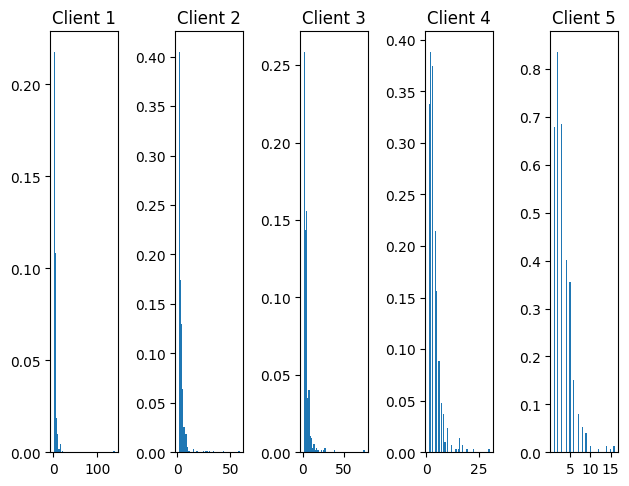

In [13]:
vals_Cora5_v2 , bins_Cora5_v2 = wandb_save_hist(degreev2_dict_cora5, 5, 5, 'Cora', 'cora5-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.7508917874806632
Average Off-Diagonal HD: 0.4961588123267119


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


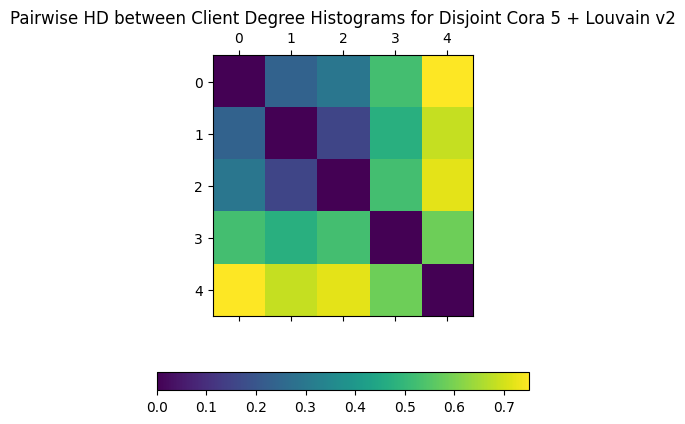

In [14]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 5 + Louvain v2"
wandb_pairwise_hellinger(vals_Cora5_v2, 5, 'cora5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.1093573071963656
Average Off-Diagonal EMD: 0.8252879686865852


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


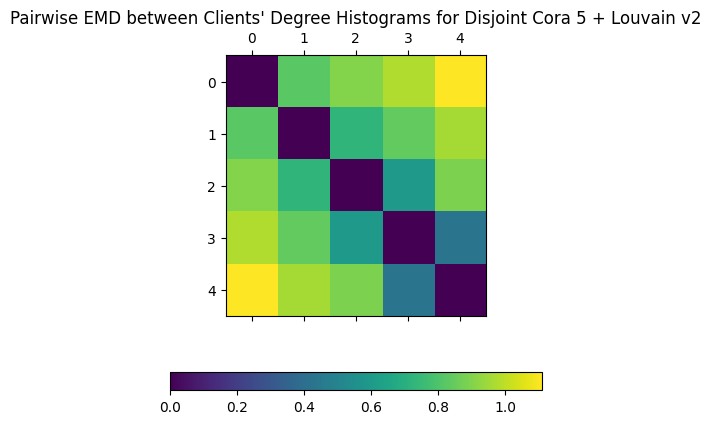

In [15]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 5 + Louvain v2"
wandb_pairwise_emd(vals_Cora5_v2 , bins_Cora5_v2, 5, 'cora5-degree-v2_emd' , t)

#### 10 Clients- v2

In [16]:
degreev2_dict_cora10 = {}
for client_id in range(10):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v2_Louvain/10/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_cora10[ds] = get_degree_list(data)
 

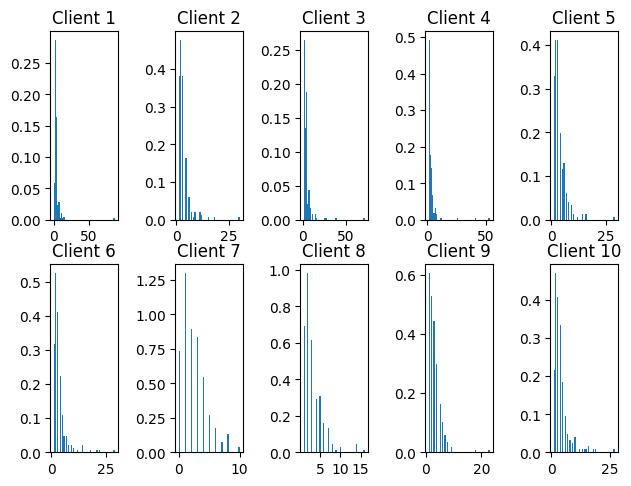

In [17]:
vals_cora10_v2, bins_cora_10_v2 = wandb_save_hist(degreev2_dict_cora10, 10, 5, 'Cora', 'cora10-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.9157113212612722
Average Off-Diagonal HD: 0.6175655592617048


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


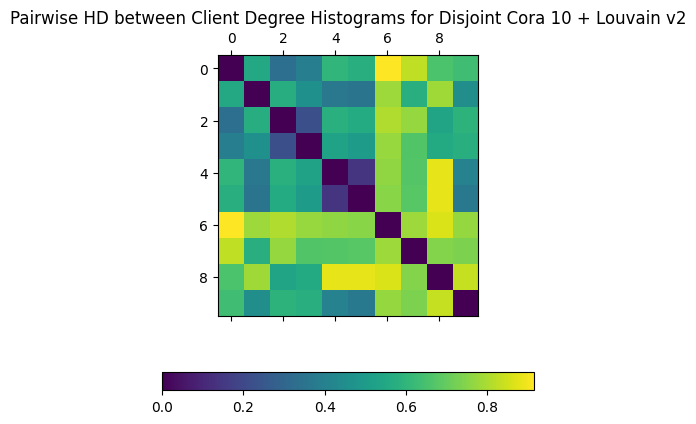

In [18]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 10 + Louvain v2"
wandb_pairwise_hellinger(vals_cora10_v2 ,10, 'cora10-degree-v1_hellinger', t)

The Min EMD: 0.0
The Max EMD: 1.4270695232449833
Average Off-Diagonal EMD: 0.8233237738179252


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


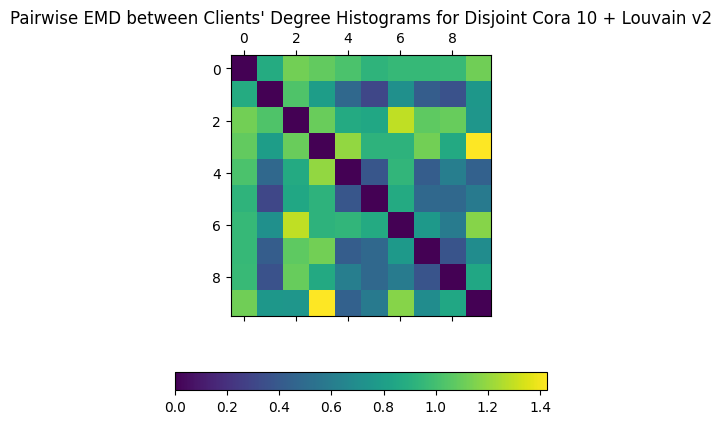

In [19]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 10 + Louvain v2"
wandb_pairwise_emd(vals_cora10_v2, bins_cora_10_v2, 10,  'cora10-degree-v2_emd' , t)

#### 20 Clients - v2 

In [20]:
degreev2_dict_cora20 = {}
for client_id in range(20):
        ds = f'{client_id}-Cora'
        partition = torch_load(datapath, f'Cora_disjoint_v2_Louvain/20/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_cora20[ds] = get_degree_list(data)
 

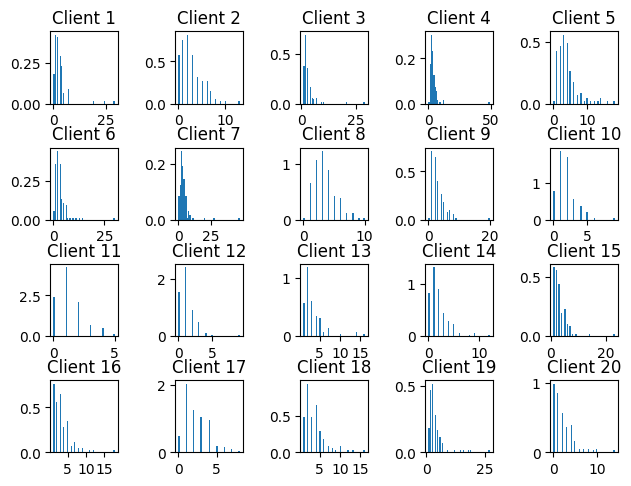

In [21]:
vals_cora20_v2, bins_cora20_v2 =wandb_save_hist(degreev2_dict_cora20, 20, 5, 'Cora', 'cora20-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.9736513013414426
Average Off-Diagonal HD: 0.770544577890023


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


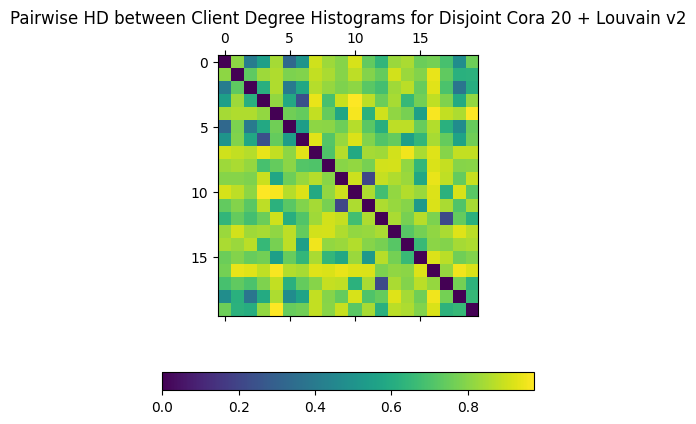

In [22]:
t = "Pairwise HD between Client Degree Histograms for Disjoint Cora 20 + Louvain v2"
wandb_pairwise_hellinger(vals_cora20_v2, 20, 'cora20-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 2.7496800000000006
Average Off-Diagonal EMD: 1.106326330741741


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


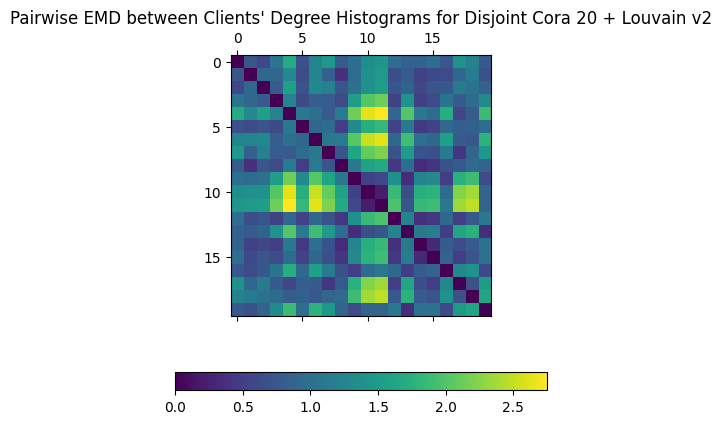

In [23]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint Cora 20 + Louvain v2"
wandb_pairwise_emd(vals_cora20_v2, bins_cora20_v2, 20, 'cora20-degree-v2_emd' , t)

## CiteSeer Dataset


,count,mean,std,min,25%,50%,75%,max
0,3327.0,2.74,3.38,0.0,1.0,2.0,3.0,99.0


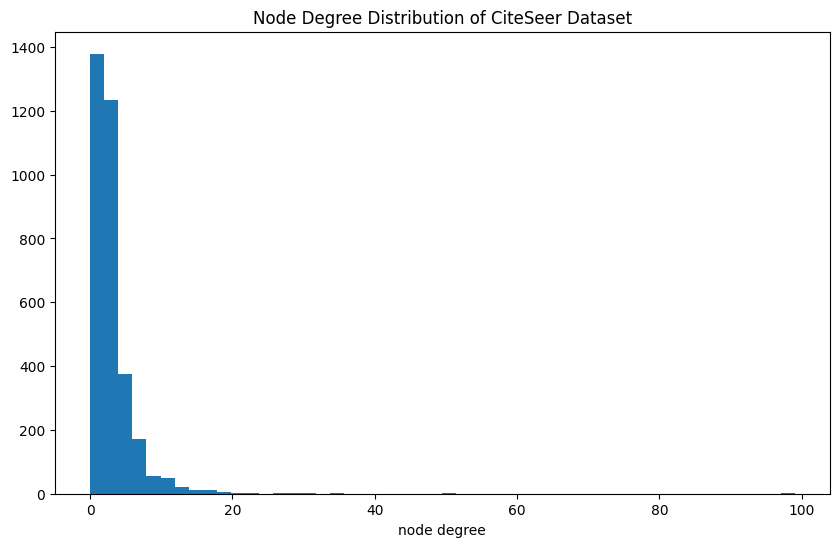

In [24]:
dataset = Planetoid(root=datapath, name='CiteSeer')
data = dataset[0]
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.title("Node Degree Distribution of CiteSeer Dataset")
plt.show()

#### 5 Clients - v2

In [25]:
degreev2_dict_seer5 =  {}
for client_id in range(5):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v2_Louvain/5/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        data = partition['client_data']
        degreev2_dict_seer5[ds] = get_degree_list(data)


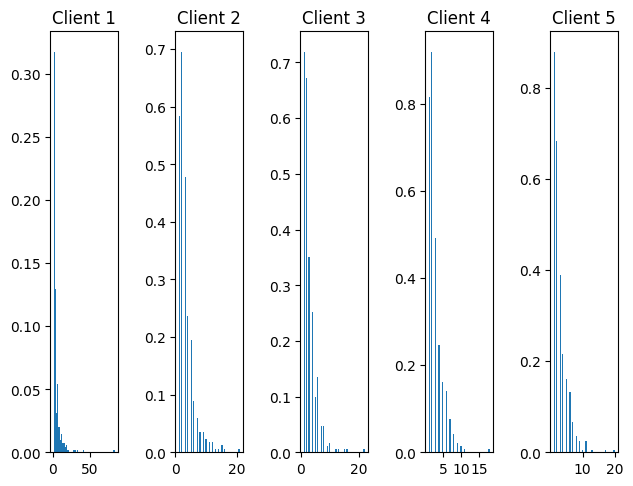

In [26]:
vals_seer5_v2, bins_seer5_v2 =wandb_save_hist(degreev2_dict_seer5, 5, 5, 'CiteSeer', 'seer5-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.6316424624102642
Average Off-Diagonal HD: 0.5439979755038712


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


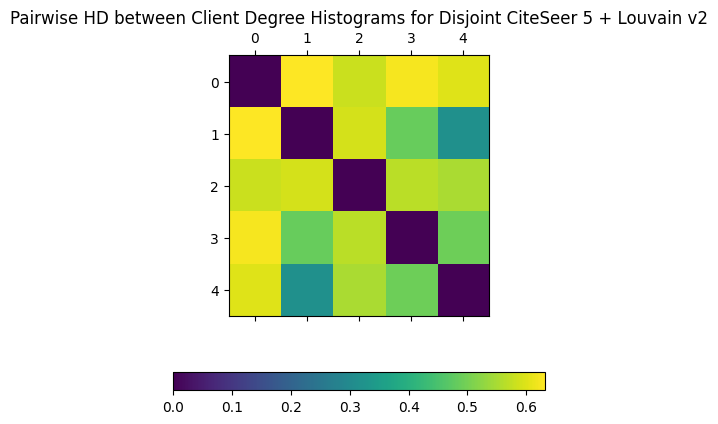

In [27]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 5 + Louvain v2"
wandb_pairwise_hellinger(vals_seer5_v2 ,5 ,'seer5-degree-v2_hellinger', t)

The Min EMD: 0.0
The Max EMD: 1.4138233890214684
Average Off-Diagonal EMD: 0.7252440263219585


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


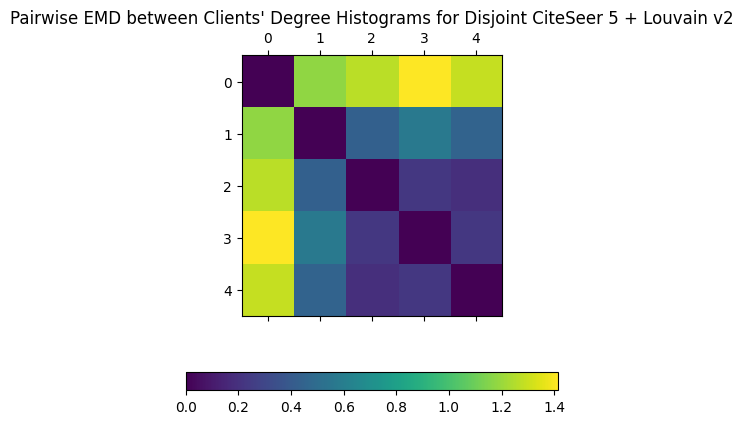

In [28]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 5 + Louvain v2"
wandb_pairwise_emd(vals_seer5_v2, bins_seer5_v2, 5, 'seer5-degree-v2_emd' , t)

#### 10 Clients - v2

In [29]:
degreev2_dict_seer10 =  {}
for client_id in range(10):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'CiteSeer_disjoint_v2_Louvain/10/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_seer10[ds] = get_degree_list(data)


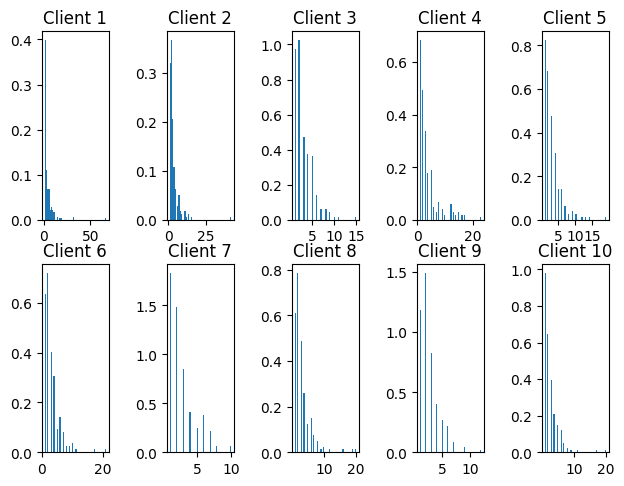

In [30]:
vals_seer10_v2, bins_seer10_v2 =wandb_save_hist(degreev2_dict_seer10, 10,5, 'CiteSeer', 'seer10-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.8537976693753886
Average Off-Diagonal HD: 0.6374145283190287


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


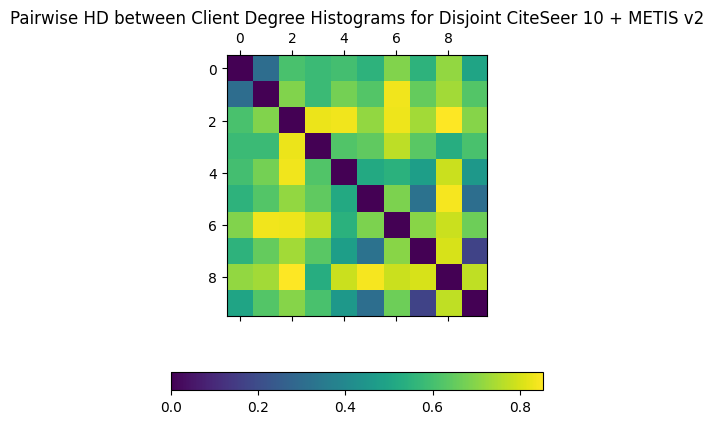

In [31]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 10 + METIS v2"
wandb_pairwise_hellinger(vals_seer10_v2, 10, 'seer10-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 1.412006446414181
Average Off-Diagonal EMD: 0.6306147950087274


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


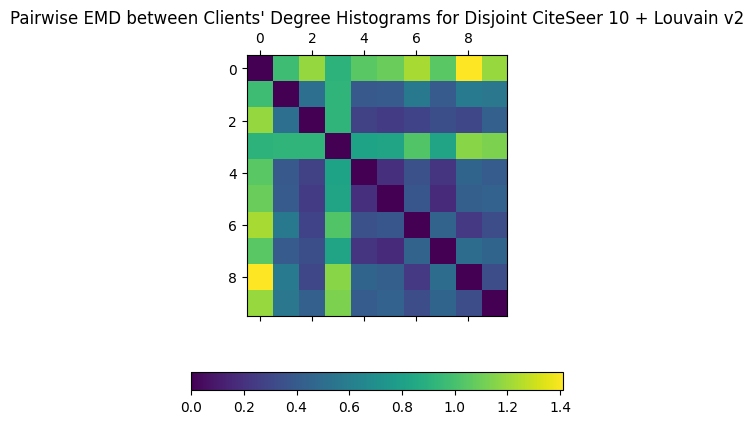

In [32]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 10 + Louvain v2"
wandb_pairwise_emd(vals_seer10_v2, bins_seer10_v2, 10, 'seer10-degree-v2_emd' , t)

#### 20 Clients - v2

In [33]:
degreev2_dict_seer20 =   {}
for client_id in range(20):
        ds = f'{client_id}-CiteSeer'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_Louvain/20/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_seer20[ds] = get_degree_list(data)



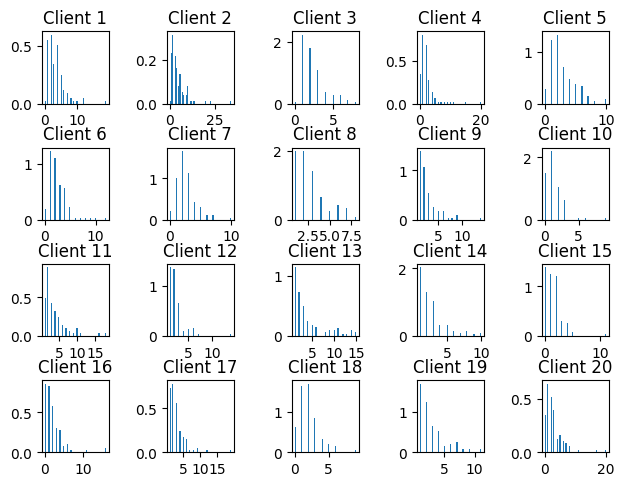

In [34]:
vals_seer20_v2, bins_seer20_v2 =wandb_save_hist(degreev2_dict_seer20, 20,5, 'CiteSeer', 'seer20-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.9909441313783897
Average Off-Diagonal HD: 0.7649394368617523


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


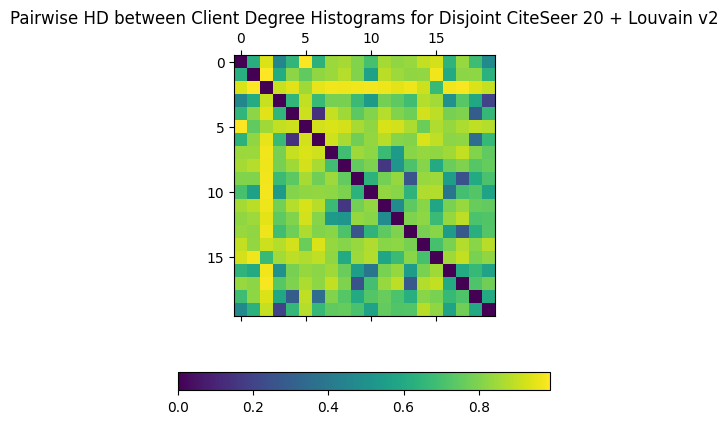

In [35]:
t = "Pairwise HD between Client Degree Histograms for Disjoint CiteSeer 20 + Louvain v2"
wandb_pairwise_hellinger(vals_seer20_v2, 20, 'seer20-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 2.983444903281898
Average Off-Diagonal EMD: 0.9782657136406884


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


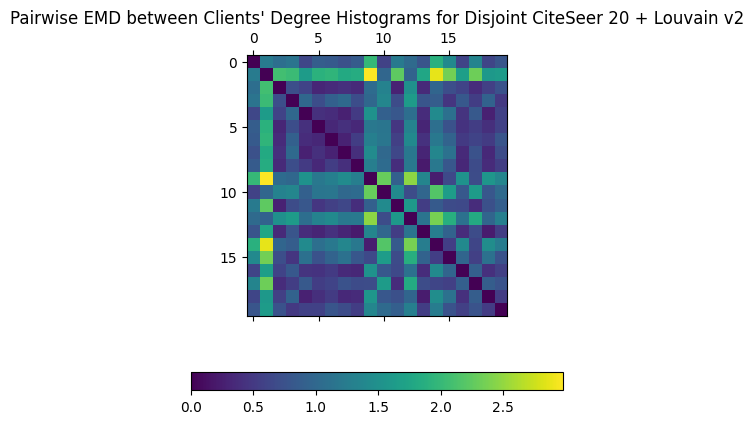

In [36]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint CiteSeer 20 + Louvain v2"
wandb_pairwise_emd(vals_seer20_v2, bins_seer20_v2, 20,  'seer20-degree-v2_emd' , t)

## PubMed Dataset

#### 5 Clients - v2

In [62]:
degreev2_dict_med5 =   {}
for client_id in range(5):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_Louvain/5/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_med5[ds] = get_degree_list(data)

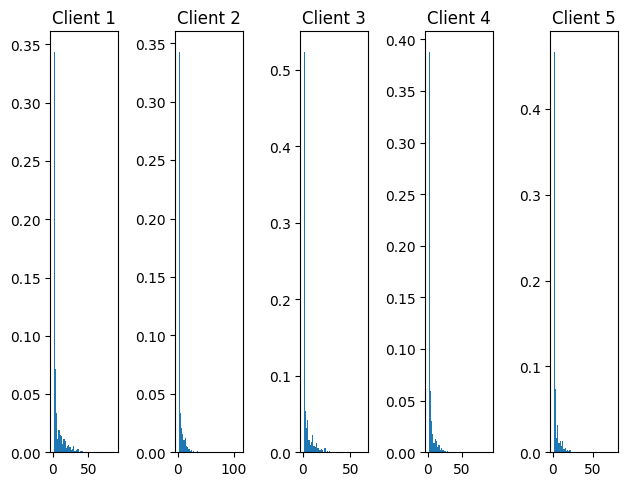

In [63]:
vals_med5_v2, bins_med5_v2 =wandb_save_hist(degreev2_dict_med5, 5,5, 'PubMed', 'med5-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.1867664104267385
Average Off-Diagonal HD: 0.13697202278852474


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


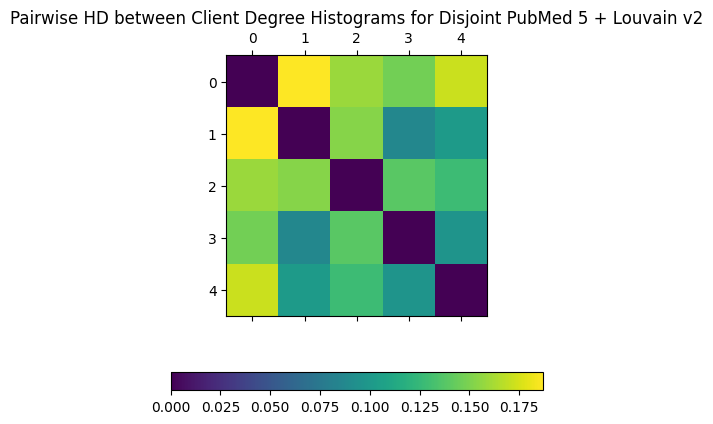

In [72]:
t = "Pairwise HD between Client Degree Histograms for Disjoint PubMed 5 + Louvain v2"
wandb_pairwise_hellinger(vals_med5_v2, 5, 'med5-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 2.3109462934698057
Average Off-Diagonal EMD: 1.1054040357197235


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


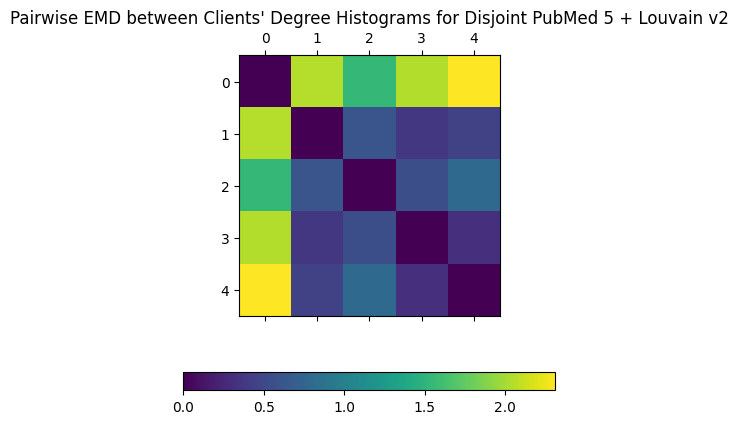

In [73]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 5 + Louvain v2"
wandb_pairwise_emd(vals_med5_v2, bins_med5_v2, 5, 'med5-degree-v2_emd' , t)

#### 10 Clients- v2

In [66]:
degreev2_dict_med10 =   {}
for client_id in range(10):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_Louvain/10/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_med10[ds] = get_degree_list(data)

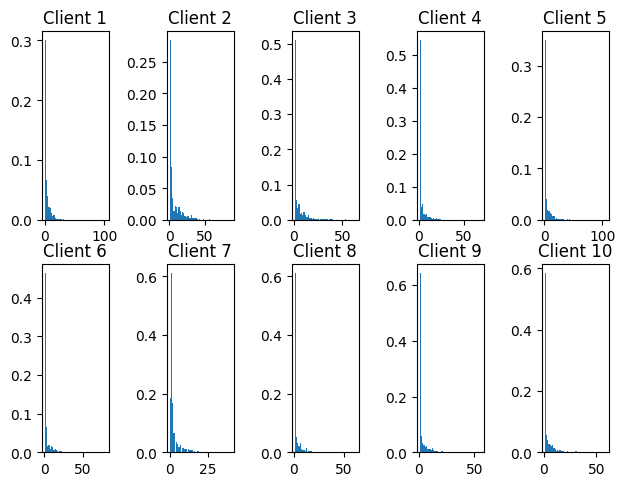

In [67]:
vals_med10_v2, bins_med10_v2 =wandb_save_hist(degreev2_dict_med10, 10,5, 'PubMed', 'med10-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.5297531894290851
Average Off-Diagonal HD: 0.21464354084363788


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


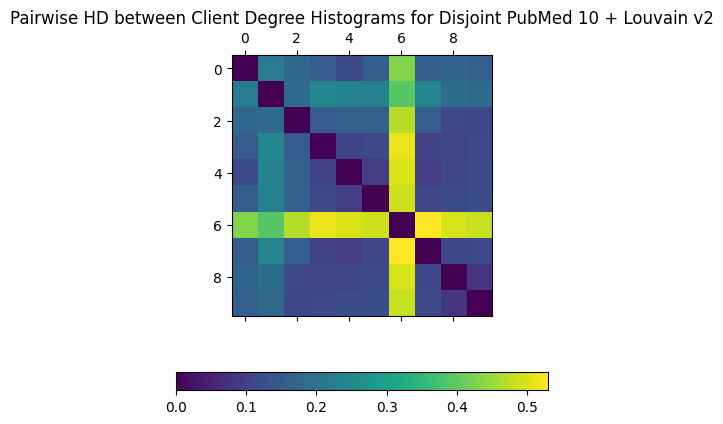

In [74]:
t = "Pairwise HD between Client Degree Histograms for Disjoint PubMed 10 + Louvain v2"
wandb_pairwise_hellinger(vals_med10_v2, 10, 'med10-degree-v2_hellinger', t)

The Min EMD: 0.0
The Max EMD: 4.342321235567945
Average Off-Diagonal EMD: 1.3790475467211312


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


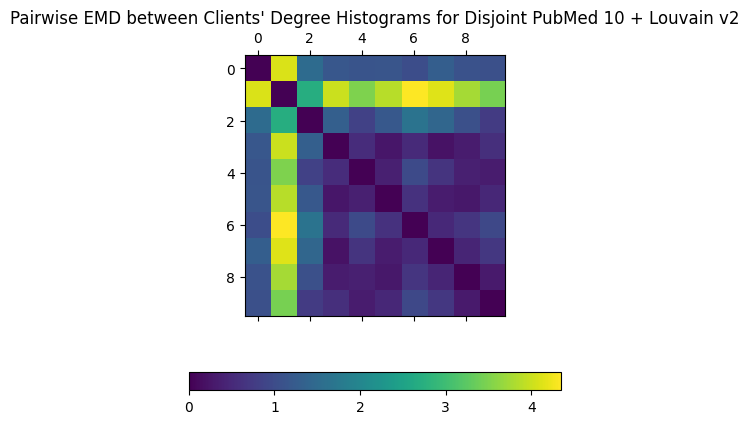

In [75]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 10 + Louvain v2"
wandb_pairwise_emd(vals_med10_v2, bins_med10_v2, 10, 'med10-degree-v2_emd' , t)

#### 20 Clients - v2

In [76]:
degreev2_dict_med20 =   {}
for client_id in range(20):
        ds = f'{client_id}-PubMed'
        partition = torch_load(datapath, f'PubMed_disjoint_v2_Louvain/20/partition_{client_id}.pt')
        #Data objects
        data = partition['client_data']
        degreev2_dict_med20[ds] = get_degree_list(data)

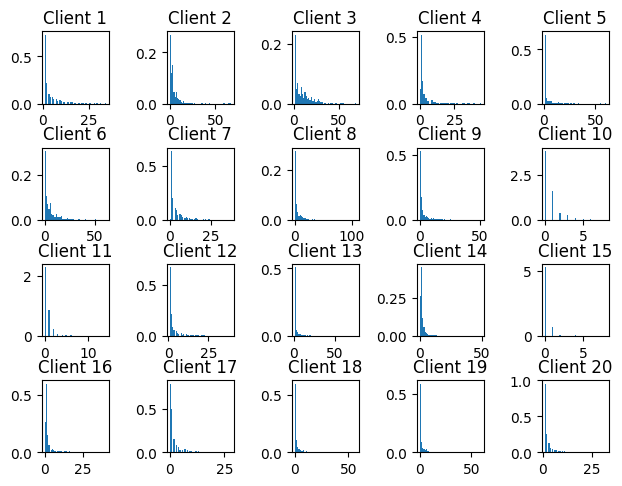

In [77]:
vals_med20_v2, bins_med20_v2 =wandb_save_hist(degreev2_dict_med20, 20,5, 'PubMed', 'med20-degree-v2-hist', 50)

The Min HD: 0.0
The Max HD: 0.9481282946598265
Average Off-Diagonal HD: 0.4206040234434079


/tmp/ipykernel_66980/127804364.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


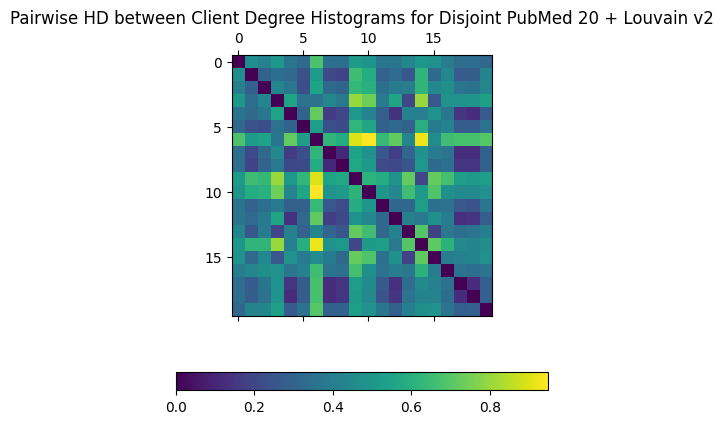

In [78]:
t = "Pairwise HD between Client Degree Histograms for Disjoint PubMed 20 + Louvain v2"
wandb_pairwise_hellinger(vals_med20_v2, 20, 'med20-degree-v2_hellinger' , t)

The Min EMD: 0.0
The Max EMD: 8.453877340616149
Average Off-Diagonal EMD: 2.05617381773112


/tmp/ipykernel_66980/1556537005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


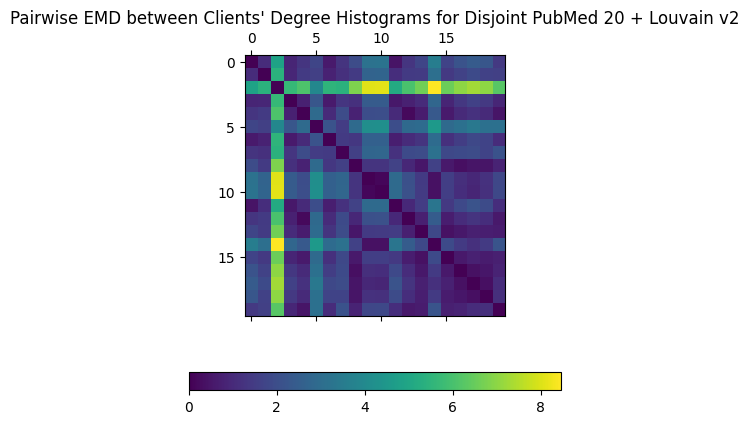

In [79]:
t = "Pairwise EMD between Clients' Degree Histograms for Disjoint PubMed 20 + Louvain v2"
wandb_pairwise_emd(vals_med20_v2, bins_med20_v2, 20, 'med20-degree-v2_emd' , t)

In [49]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
